In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import flygym.mujoco
from flygym.mujoco.arena.tethered import Tethered
from tqdm import trange
from pathlib import Path

output_path = Path("./outputs")
output_path.mkdir(exist_ok=True)

In [2]:
fly_traj = []
run_time = 1.0
cam_pos = "right"
cam_name = f"Animat/camera_{cam_pos}"
kp = 50.0
stifness = 10.0
damping = 10.0
seed = 0

sim_params = flygym.mujoco.Parameters(
    timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.05,
    enable_adhesion=False,  # THIS HAS CHANGED
    render_camera=cam_name,
    tarsus_damping=damping,
    tarsus_stiffness=stifness
)
nmf = flygym.mujoco.NeuroMechFly(
    sim_params=sim_params,
    init_pose="stretch",
    actuated_joints=flygym.mujoco.preprogrammed.all_leg_dofs,
    control="position",
    xml="mjcf_ikpy_model",
    arena=Tethered(),
    self_collisions = "none"
)

target_num_steps = int(run_time / nmf.sim_params.timestep)

In [3]:
# build a dataset that moved one dof at a time between -pi/2 and pi/2 and record the position of the fly for the frontleg first dof
n_jts = len(nmf.actuated_joints)

data_block = np.zeros((n_jts, target_num_steps))
base_pose_dof = {"Coxa":0 , "Coxa_roll":0, "Coxa_yaw":0, "Femur":-np.pi/2, "Femur_roll":0, "Tibia":np.pi/2, "Tarsus1":-np.pi/2}
seg_to_moove = "F"
joint_period = target_num_steps//len(base_pose_dof)

mooved_joints_index = 0

for i, joint in enumerate(nmf.actuated_joints):
    joint_name = "_".join(joint.split("_")[1:])
    segment = joint_name[1]
    side = joint_name[0]
    if side == "R":    
        dof = joint_name[2:]
        start_angle = base_pose_dof[dof]
        data_block[i, :] = start_angle
        start_angle_mirrored = start_angle
        i_mirror = nmf.actuated_joints.index(f"joint_L{segment}"+dof)
        if "roll" in dof or "yaw" in dof:
            start_angle_mirrored = -start_angle
        data_block[i_mirror, :] = start_angle_mirrored
        if segment == seg_to_moove:
            smooth_traj = None
            if start_angle == 0:
                smooth_traj = np.sin(np.linspace(0, 2*np.pi, joint_period))*np.pi/2
            else:
                smooth_traj = np.cos(np.linspace(0, 2*np.pi, joint_period))*start_angle

            joint_mvt_time = np.arange(mooved_joints_index*joint_period, (mooved_joints_index+1)*joint_period)
            
            data_block[i, joint_mvt_time] = smooth_traj
            if "roll" in dof or "yaw" in dof:
                data_block[i_mirror, joint_mvt_time] = -smooth_traj
            else:
                data_block[i_mirror, joint_mvt_time] = smooth_traj
            mooved_joints_index += 1


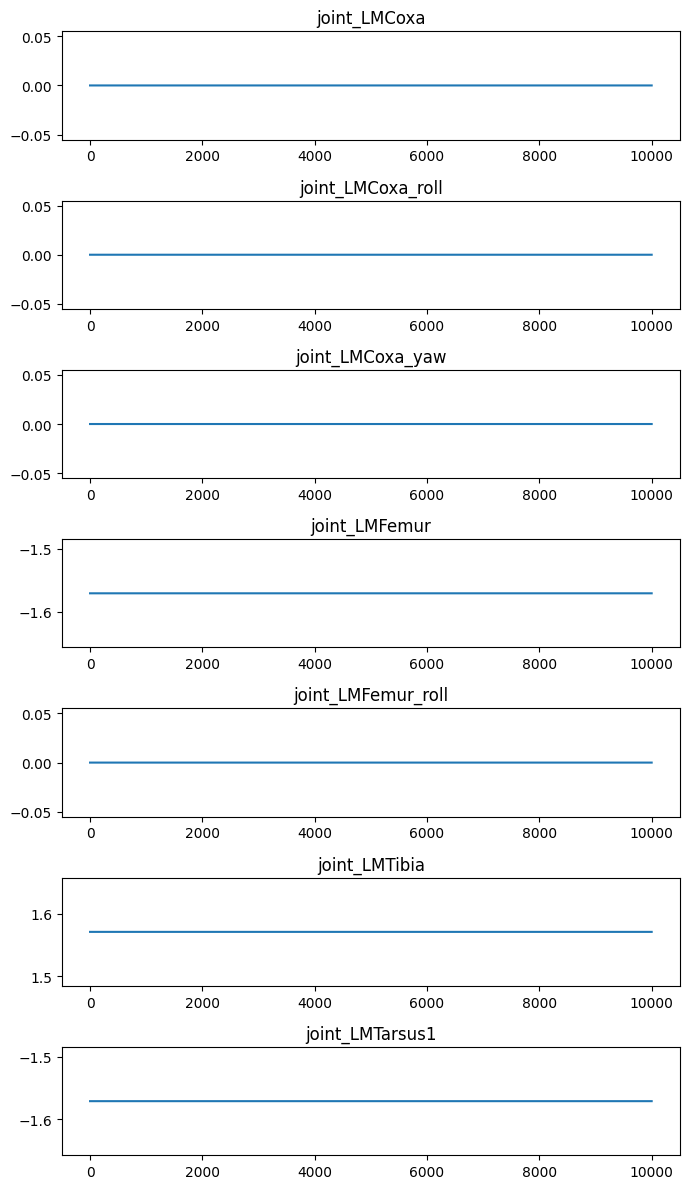

In [4]:
fig, axs = plt.subplots(7, 1 , figsize=(7, 12))
for i, ax in zip(range(7, 14), axs):
    ax.plot(data_block[i, :])
    ax.set_title(nmf.actuated_joints[i])
plt.tight_layout()

In [5]:
# set all not leg geoms to be transparent
for geom in nmf.model.find_all("geom"):
    if not geom.name[1] == seg_to_moove:
        #nmf.physics.named.model.geom_rgba[f"Animat/{geom.name}"] = [0.5, 0.5, 0.5, 0]
        pass

In [6]:
obs, info = nmf.reset()

xml = "mjcf_ikpy_model_clean_sym_novis_rotmesh"

for view in ["front", "right", "top"]:
    end_effector_pos = []
    sim_params.render_camera = f"Animat/camera_{view}"
    nmf = flygym.mujoco.NeuroMechFly(
        sim_params=sim_params,
        init_pose="stretch",
        actuated_joints=flygym.mujoco.preprogrammed.all_leg_dofs,
        control="position",
        xml=xml,
        arena=Tethered(),
        self_collisions = "none"
    )

    # set all not leg geoms to be transparent
    for geom in nmf.model.find_all("geom"):
        if not geom.name[1] == seg_to_moove:
            #nmf.physics.named.model.geom_rgba[f"Animat/{geom.name}"] = [0.5, 0.5, 0.5, 0]
            pass
        
    obs, info = nmf.reset()
    # stabilization phase: converge slowly to the desired position
    n_stab_steps = 100
    for i in trange(100):
        interm_pos = (obs["joints"][0]*(100-i) + data_block[:, 0]*i )/100
        action = {"joints": interm_pos}
        obs, reward, terminated, truncated, info = nmf.step(action)
        nmf.render()

    for i in trange(target_num_steps):
        # here, we simply use the recorded joint angles as the target joint angles
        joint_pos = data_block[:, i]
        action = {"joints": joint_pos}
        obs, reward, terminated, truncated, info = nmf.step(action)
        end_effector_pos.append(obs["end_effectors"].copy())
        nmf.render()

    nmf.save_video(output_path / f"assess_symetry_{seg_to_moove}_cam{view}_xml{xml}.mp4", 0)

100%|██████████| 10000/10000 [00:08<00:00, 1166.72it/s]


# Should compare the x and z positions of the legs

In [7]:
end_effector_pos = np.array(end_effector_pos)

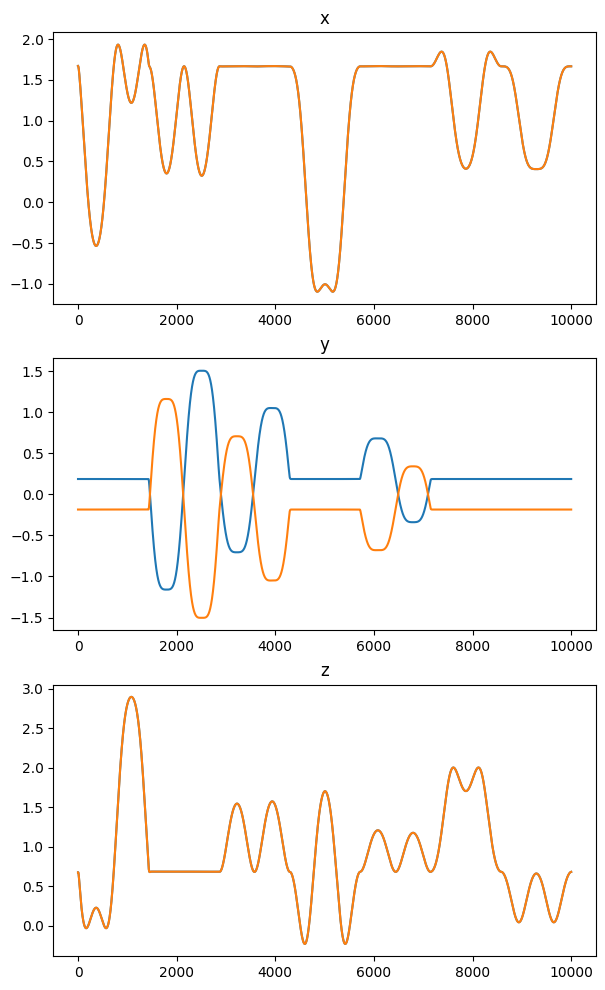

In [8]:
end_effector_to_plot = [i for i, name in enumerate(nmf._last_tarsalseg_names) if seg_to_moove in name]
fig, axs = plt.subplots(3, 1, figsize=(7, 12))
coord_map = ["x", "y", "z"]

for i, (coord, ax) in enumerate(zip(coord_map, axs)):
    for ee in end_effector_to_plot:
        ax.plot(end_effector_pos[:, ee, i], label=f"EE {ee}")
    ax.set_title(coord)

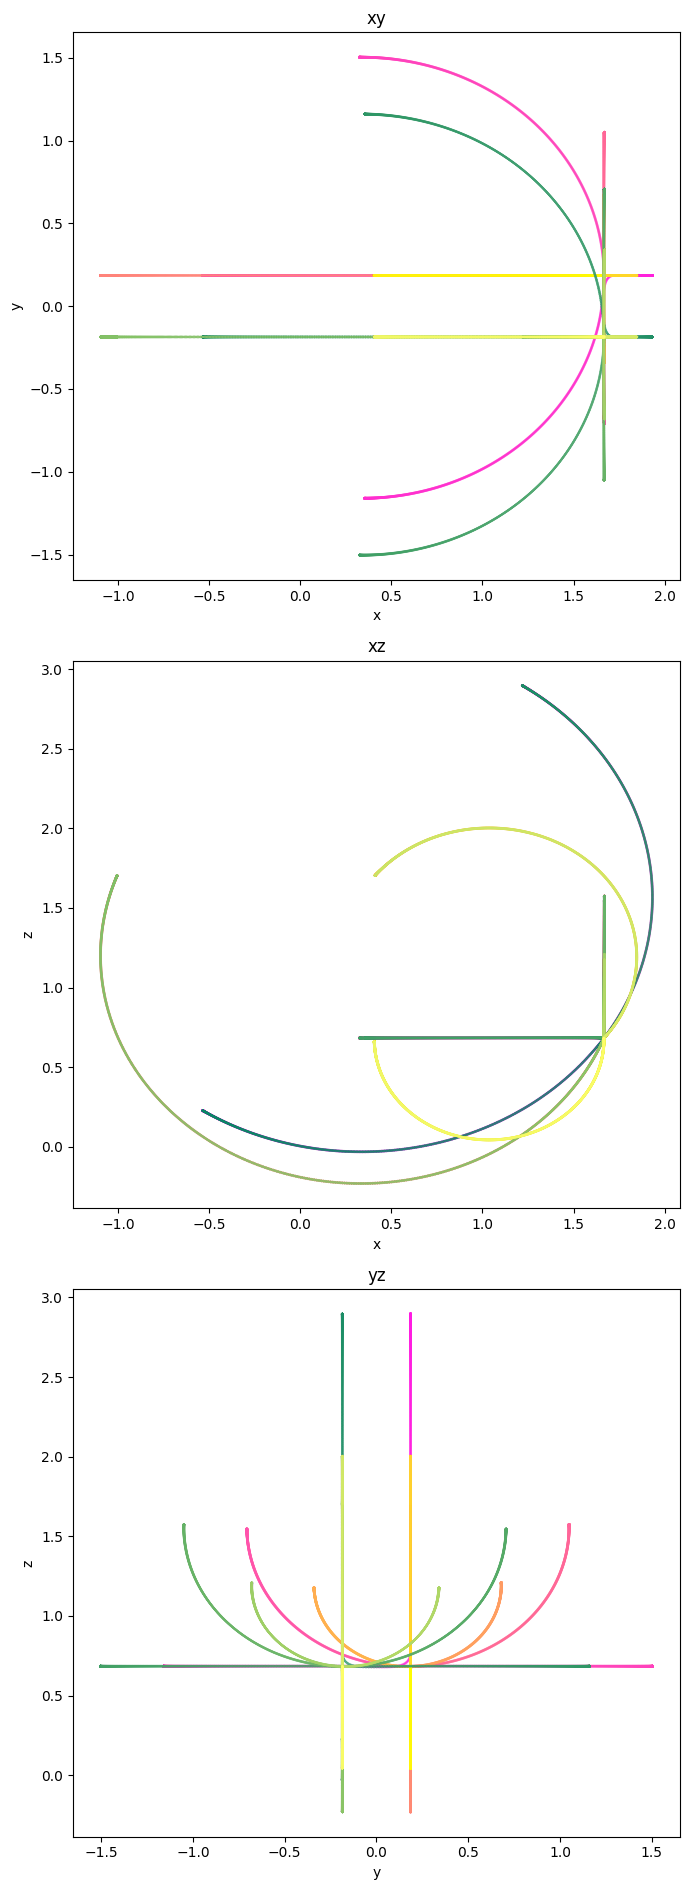

In [9]:
coord_map = {"x":0, "y":1, "z":2}
time = np.arange(0, target_num_steps)
fig, axs = plt.subplots(3, 1, figsize=(7, 19))
for coords, ax in zip(["xy", "xz", "yz"], axs):

    ax.scatter(end_effector_pos[:, end_effector_to_plot[0], coord_map[coords[0]]],
             end_effector_pos[:, end_effector_to_plot[0], coord_map[coords[1]]], 
             c=time, cmap="spring", marker="o", s=1, alpha=0.5)
    ax.scatter(end_effector_pos[:, end_effector_to_plot[1], coord_map[coords[0]]],
                end_effector_pos[:, end_effector_to_plot[1], coord_map[coords[1]]], 
                c=time, cmap="summer", marker="x", s=1, alpha=0.5)
    ax.set_title(f"{coords[0]}{coords[1]}")
    ax.set_xlabel(coords[0])
    ax.set_ylabel(coords[1])

plt.tight_layout()

# Compare different xmls

In [10]:
obs, info = nmf.reset()

xmls = ["mjcf_ikpy_model", "mjcf_ikpy_model_sym", "mjcf_ikpy_model_clean", "mjcf_ikpy_model_clean_sym", "mjcf_ikpy_model_clean_sym_novis", "mjcf_ikpy_model", "mjcf_ikpy_model_clean_sym_novis_rotmesh"]
xml_ee_pos = []
n_stab_steps = 100

sim_params = flygym.mujoco.Parameters(
    timestep=1e-4,
    render_mode="headless",
    enable_adhesion=False,  # THIS HAS CHANGED
    tarsus_damping=damping,
    tarsus_stiffness=stifness,
    joint_stiffness = 1.0,
    joint_damping = 1.0,
    actuator_kp = 70.0,
)

for xml in xmls :
    np.random.seed(0)
    
    end_effector_pos = []
    nmf = flygym.mujoco.NeuroMechFly(
        sim_params=sim_params,
        init_pose="stretch",
        actuated_joints=flygym.mujoco.preprogrammed.all_leg_dofs,
        control="position",
        xml=xml,
        arena=Tethered(),
        self_collisions = "none",
        floor_collisions= "none"
    )

    obs, info = nmf.reset()

    # stabilization phase: converge slowly to the desired position
    for i in trange(n_stab_steps):
        interm_pos = (obs["joints"][0]*(n_stab_steps-i) + data_block[:, 0]*i )/n_stab_steps
        action = {"joints": interm_pos}
        obs, reward, terminated, truncated, info = nmf.step(action)

    for i in trange(target_num_steps):
        # here, we simply use the recorded joint angles as the target joint angles
        joint_pos = data_block[:, i]
        action = {"joints": joint_pos}
        obs, reward, terminated, truncated, info = nmf.step(action)
        end_effector_pos.append(obs["end_effectors"].copy())
    xml_ee_pos.append(np.array(end_effector_pos))   


100%|██████████| 10000/10000 [00:02<00:00, 3626.95it/s]


In [11]:
xml_ee_pos = np.array(xml_ee_pos)

In [12]:
nmf._last_tarsalseg_names

['LFTarsus5', 'LMTarsus5', 'LHTarsus5', 'RFTarsus5', 'RMTarsus5', 'RHTarsus5']

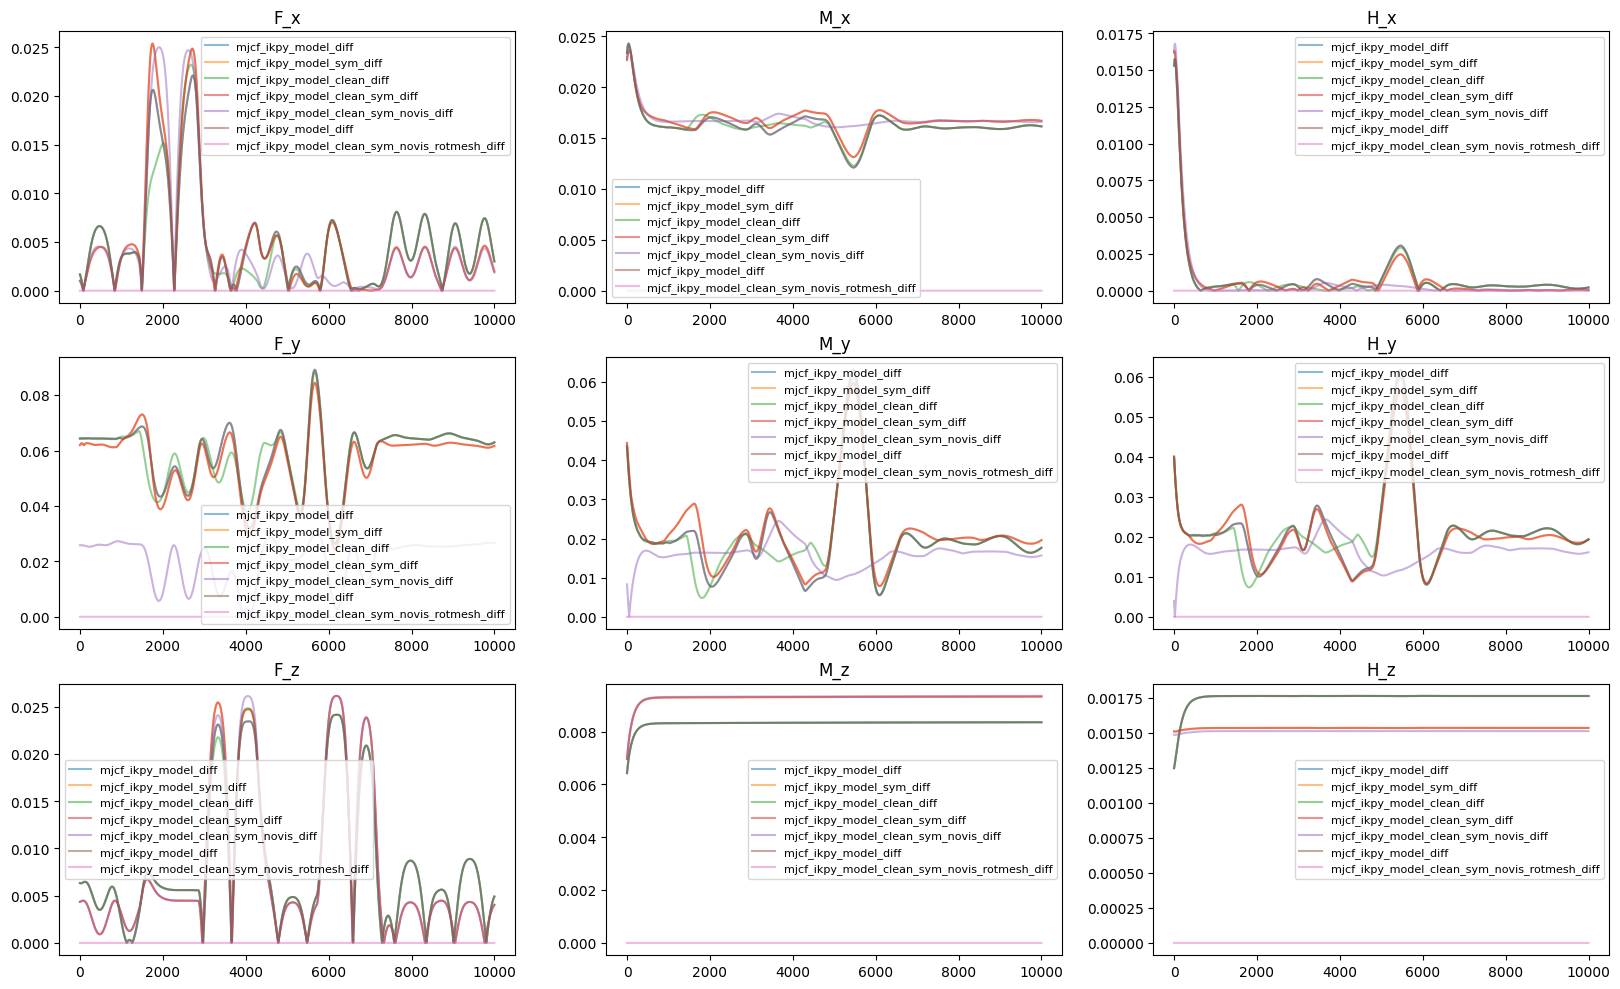

: 

In [13]:
fig, axs = plt.subplots(3, 3, figsize=(20, 12))
coord_map = ["x", "y", "z"]

for i, coord in enumerate(coord_map):
    for j, leg in enumerate(["F", "M", "H"]):
        end_effector_to_plot = [i for i, name in enumerate(nmf._last_tarsalseg_names) if leg == name[1]]
        for k, xml in enumerate(xmls):
            mirror_factor = 1
            if coord == "y":
                mirror_factor = -1
            ee_pos_diff = xml_ee_pos[k, :, end_effector_to_plot[0], i]*mirror_factor - xml_ee_pos[k, :, end_effector_to_plot[1], i]
            axs[i][j].plot(np.abs(ee_pos_diff), label=f"{xml}_diff", alpha=0.5)

        
        axs[i][j].set_title(f"{leg}_{coord}")
        axs[i][j].legend(fontsize=8)